# 3次関数の回帰問題をベイズ推論で解く
ライブラリへの理解を深める良い方法は,実例を自分の問題に適用することです.

単回帰分析の実例があったので,少し複雑な3次関数の回帰問題に挑戦します.


最初に,必要なライブラリをインポートします.

In [31]:
import arviz as az
import numpy as np
import pymc as pm

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

グラフのスタイルや乱数の種を初期化します.

また,説明変数や目的変数の標準化関数を設定します.

In [32]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series, mean, std):
    """NumPy1次元配列の標準化"""
    return (series - mean) / std

def inverse_standardize(series, mean, std):
    """NumPy1次元配列の標準化の逆演算(今回は使用しない)"""
    return std * series + mean

## 問題設定
今回は,$y = \frac{x^3}{3} - x$に正規分布のノイズを加えたデータセットの回帰問題に挑戦します.

データの分布を図1に示します.

(-3.0, 3.0)

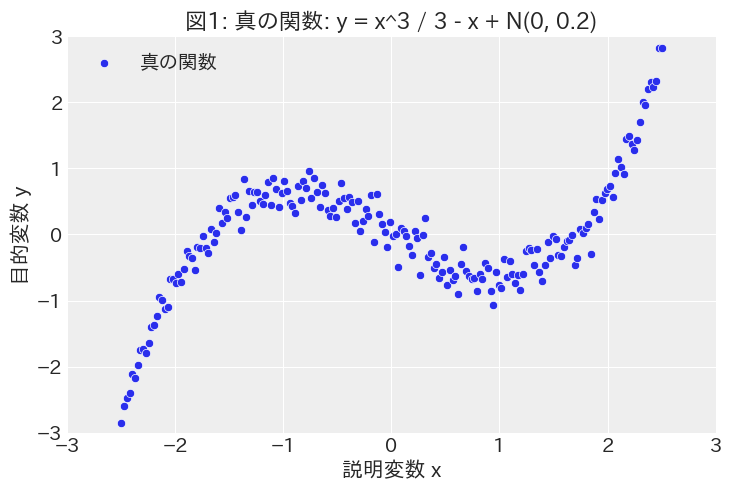

In [43]:
x = np.linspace(-2.5, +2.5, 200)
noise = np.random.normal(loc = 0.0, scale = 0.2, size = x.shape[0])
y = x ** 3 / 3.0 - x + noise

sns.scatterplot(x = x, y = y, label = "真の関数")

plt.title("図1: 真の関数: y = x^3 / 3 - x + N(0, 0.2)")
plt.xlabel("説明変数 x")
plt.ylabel("目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

データセット全体のうち,$x < 1$のデータを訓練データセット, $x \geq 1$のデータをテストデータセットとします.
今回の問題は,$x < 1$のデータを用いて,$x \geq 1$の目的変数を予測することとなります.

図2は訓練データセットの散布図です.
切り取られた右端のデータセットを予測することが,今回の課題になります.

(-3.0, 3.0)

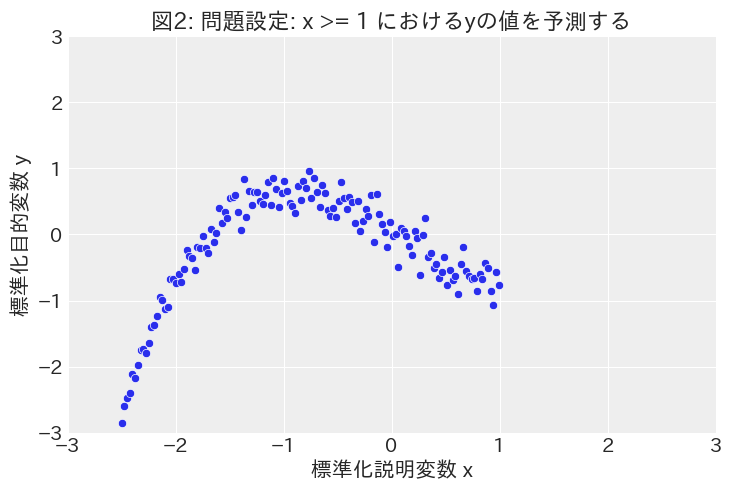

In [44]:
train_x, train_y = x[x < 1], y[x < 1]
test_x, test_y = x[x >= 1], y[x >= 1]

sns.scatterplot(x = train_x, y = train_y)
plt.title("図2: 問題設定: x >= 1 におけるyの値を予測する")
plt.xlabel("標準化説明変数 x")
plt.ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

### 標準化
MCMCのサンプラーの効率を高めるために説明変数と目的変数を標準化します.

後で予測値を可視化する時に勘違いしないように標準化した訓練データの散布図を図示します(図3).

Text(0, 0.5, '標準化目的変数 y')

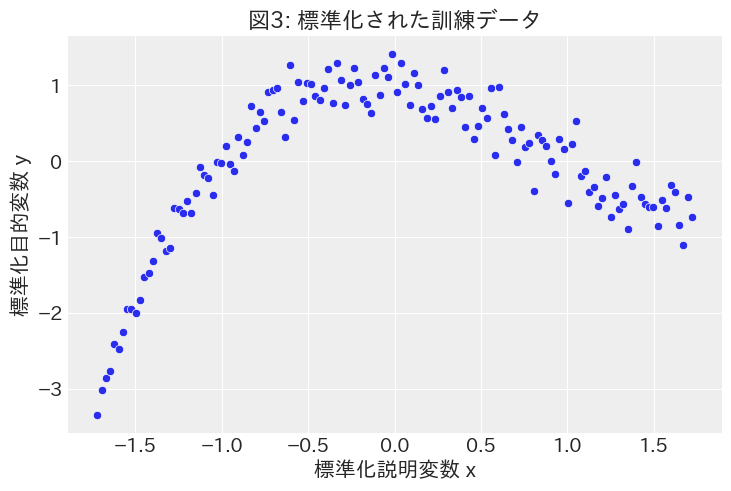

In [45]:
mean_x = np.mean(train_x)
std_x = np.std(train_x)
mean_y = np.mean(train_y)
std_y = np.std(train_y)

scaled_train_x = standardize(train_x, mean_x, std_x)
scaled_train_y = standardize(train_y, mean_y, std_y)

scaled_test_x = standardize(test_x, mean_x, std_x)
scaled_test_y = standardize(test_y, mean_y, std_y)

sns.scatterplot(x = scaled_train_x, y = scaled_train_y)
plt.title("図3: 標準化された訓練データ")
plt.xlabel("標準化説明変数 x")
plt.ylabel("標準化目的変数 y")

## モデル定義
タイトルに答えが書いてありますが,一応3次関数でモデルを作成する理由を書いておきましょう.

1. 散布図のピークが1つだけ見えるので,2次関数か3次関数で近似するのが無難.
1. 標準化したデータの散布図が線対称ではないので,3次関数を選択する.
    * $x = -1.5, 1.5$の目的変数の値が倍違う.

したがって,今回の確率モデルは下記の式で表されます.
$$
\begin{align}
y &\sim \mathcal{N} \bigl( \mu , \sigma ^2 \bigr)\\
\mu &= \beta _0 + \beta _1 x + \beta _2 x^2 + \beta _3 x^3\\
\sigma &\sim \mathcal{N} \bigl( 0 , 1)\\
\beta _i &\sim \mathcal{N} \bigl( 0 , 1)
\end{align}
$$

$\beta _i$と$\sigma$の確率分布のパラメータを標準正規分布と仮定します(事前分布).
この確率モデルをプログラミングすると,次のセルの通りになります.

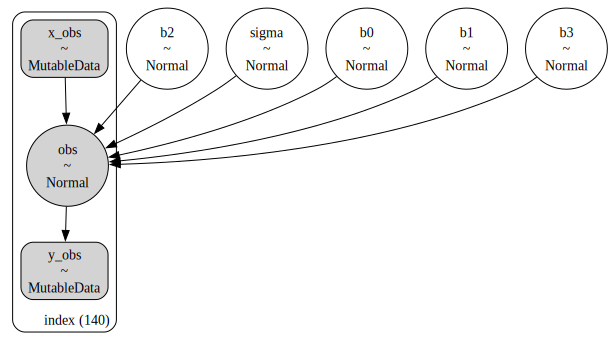

In [50]:
# モデル定義
coords = {"index": np.arange(0, len(scaled_train_y))}
with pm.Model() as model:
    # 観測値
    x_obs = pm.MutableData("x_obs", scaled_train_x, dims = "index")
    y_obs = pm.MutableData("y_obs", scaled_train_y, dims = "index")

    # 3次関数の係数
    b0 = pm.Normal("b0", 0.0, 1.0)
    b1 = pm.Normal("b1", 0.0, 1.0)
    b2 = pm.Normal("b2", 0.0, 1.0)
    b3 = pm.Normal("b3", 0.0, 1.0)

    # 目的変数の誤差の確率分布
    mu = b0 + b1 * x_obs + b2 * x_obs ** 2 + b3 * x_obs ** 3
    sigma = pm.Normal("sigma", mu = 0, sigma = 1)
    pm.Normal("obs", mu = mu, sigma = sigma, observed = y_obs, dims = "index")

# モデル構造の可視化
pm.model_to_graphviz(model)

### 事後分布の生成
モデル構造が設計どおりであることを確認したら,次はMCMCに基づく事後分布の生成を行います.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b1, b2, b3, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'b3'}>, <Axes: title={'center': 'b3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

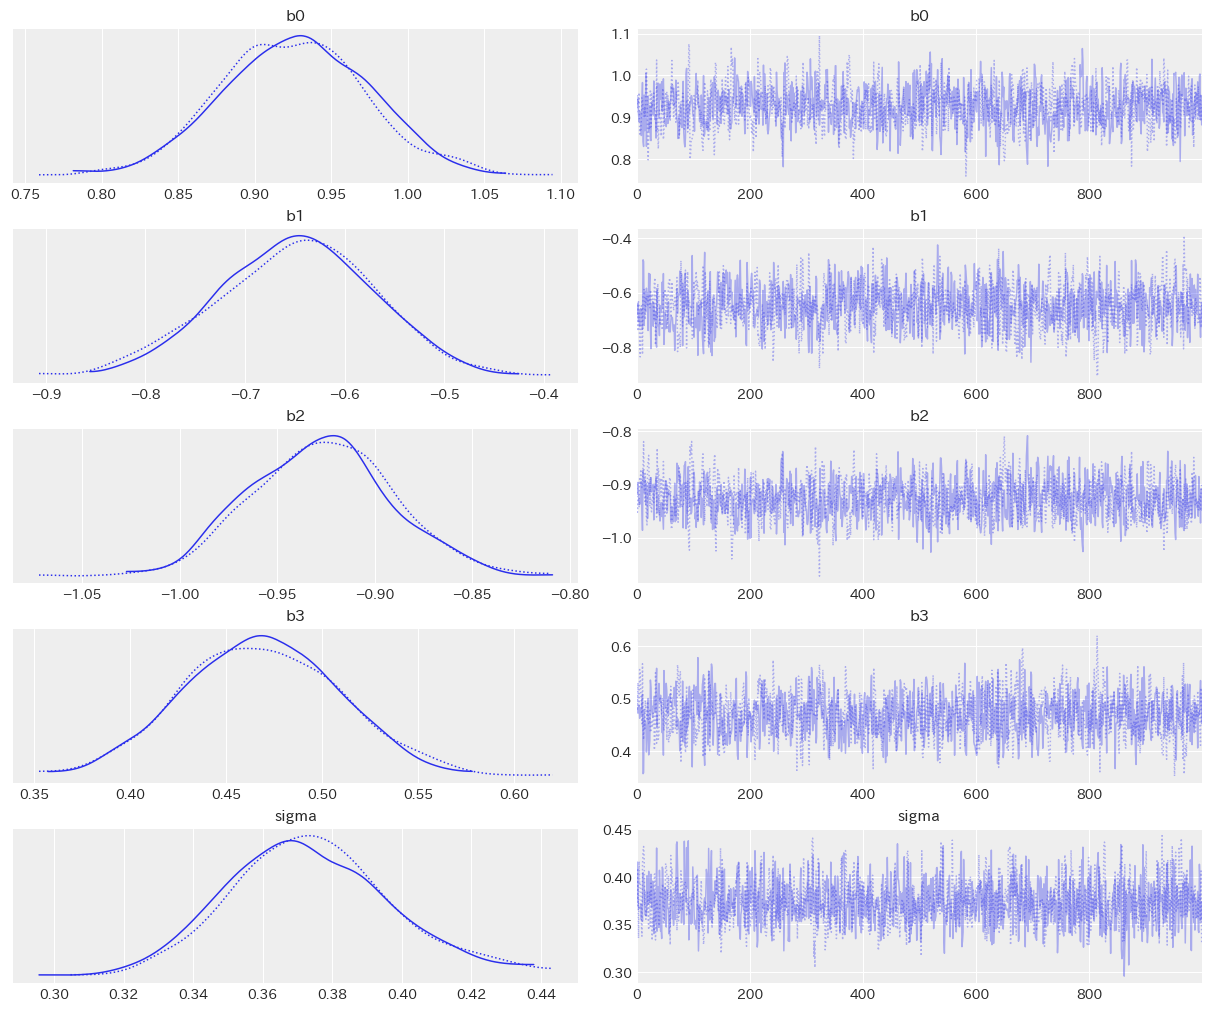

In [37]:
with model:
    # 事後分布の生成
    idata = pm.sample(draws = 1000, tune = 1000, chains = 2, target_accept = 0.95, random_seed = rng)

# サンプリングトレースの可視化
az.plot_trace(idata)

サンプリングトレースが問題ないことを確認したら,モデルの評価に移ります.

判断基準
* 左側の分布が1箇所に収束している.
* 右側の分布に黒い縦線(発散)が無い.

## モデルの評価
モデルの係数を可視化します.

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

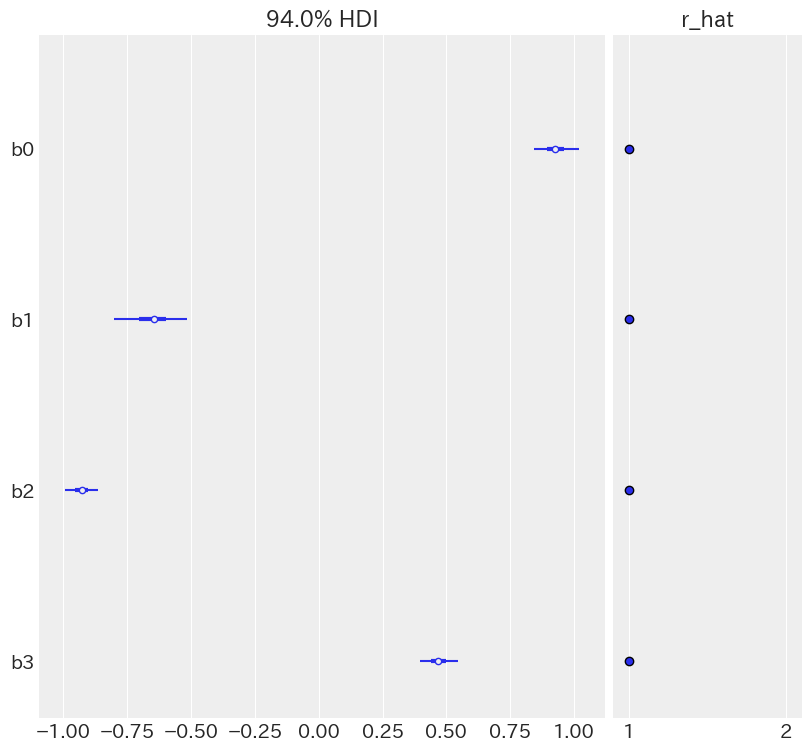

In [48]:
az.plot_forest(idata, combined = True, var_names = ['b0', 'b1', 'b2', "b3"], r_hat = True)

```r_hat```が1に近いとパラメータ推定は安定していると考えられます.

## データの予測
```pm.MutableData```に観測値を登録することで,**モデルを書き写さないで予測値を算出できます**.

モデルが複雑になるとコピペミスが発生しやすいので,コピペしないで済む機能は便利です.

In [39]:
with model:
    # テストデータの登録
    pm.set_data(
        {
            "x_obs": scaled_test_x,
            # 目的変数はダミー変数を入力する.
            "y_obs": np.arange(0, len(scaled_test_x)),
        },
        coords = {"index": np.arange(0, len(scaled_test_x))},
    )

    # 予測値の計算
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


予測の妥当性を確認するために次の図が良く使われるようですが,3次関数の近似だとうまく機能しているようには見えません.

<Axes: xlabel='obs'>

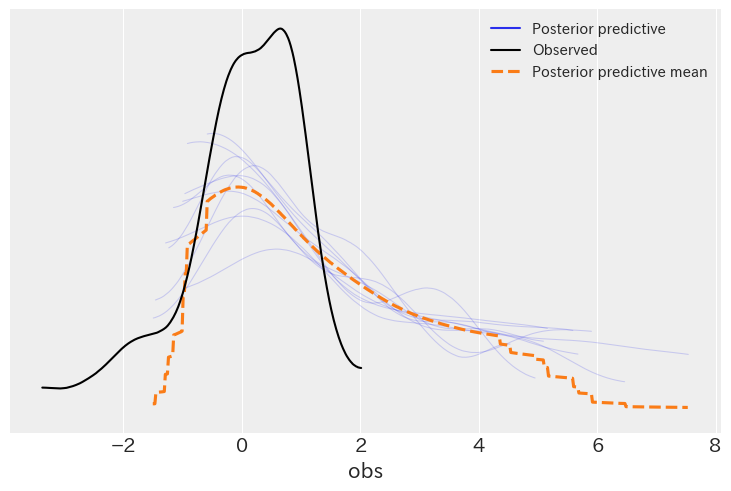

In [40]:
# 予測値の分布
az.plot_ppc(idata, num_pp_samples = 10)

テストデータの予測値をプロットします.

Text(0, 0.5, '標準化目的変数 y')

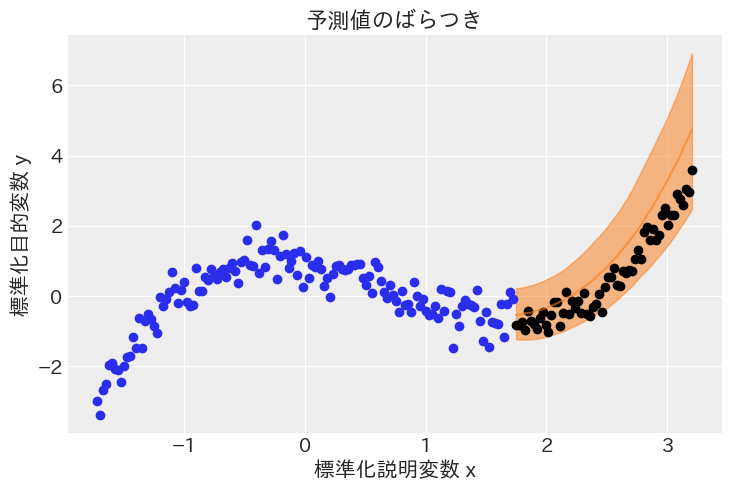

In [41]:
_, ax = plt.subplots()

# 予測値の平均値
ax.plot(
    scaled_test_x, idata.posterior_predictive["obs"].mean(("chain", "draw")),
    label = "Mean outcome", color = "C1", alpha = 0.6
)
# 予測値のばらつき
az.plot_hdi(scaled_test_x, idata.posterior_predictive["obs"])
# 訓練データ
ax.scatter(scaled_train_x, scaled_train_y)
ax.scatter(scaled_test_x, scaled_test_y, marker = "o", color = "k")


ax.set_title("図4: 予測値のばらつき")
ax.set_xlabel("標準化説明変数 x")
ax.set_ylabel("標準化目的変数 y")

予測範囲にテストデータが収まっていたので、このモデルの予測は妥当だと考えられます.

元のスケールに戻す方法が良くわからないので,今回はこのままにしておきます.

In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Apr 03 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

japanize_matplotlib: 1.1.3
seaborn            : 0.13.2
xarray             : 2024.3.0
pymc               : 5.12.0
matplotlib         : 3.8.3
numpy              : 1.26.4
arviz              : 0.17.1

Watermark: 2.4.3

